In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn import svm

# Data Modeling

## 데이터 수집

In [2]:
df = pd.read_csv('C:/workspaces/project/kaggle/data/d_final.csv', encoding = 'utf-8')

In [3]:
df.head()

,id,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,...,tobacco,contact_other_covid,covid_res,icu,DEATH,d_ent,d_sym,d_last,diff_days,age_grp
0,167386,1,2,2,54,2,2,2,2,2,...,2,3,1,2,0,2020-04-06,2020-04-01,2020-06-29,89,3.0
1,0b5948,2,2,1,30,2,2,2,2,2,...,2,3,1,2,0,2020-04-17,2020-04-10,2020-06-29,80,2.0
2,0d01b5,1,2,2,60,2,1,2,2,2,...,2,3,1,2,1,2020-04-13,2020-04-13,2020-04-22,9,4.0
3,1beec8,2,2,1,47,2,1,2,2,2,...,2,3,1,1,1,2020-04-16,2020-04-16,2020-04-29,13,3.0
4,1.75E+56,2,2,2,63,2,2,2,2,2,...,2,3,1,2,0,2020-04-22,2020-04-13,2020-06-29,77,4.0


In [4]:
df['DEATH'].value_counts()

0    88993
1    32402
Name: DEATH, dtype: int64

## 사망기간 예측을 위한 생존자 데이터 제거
- 사망한 사람 데이터만 필요함

In [5]:
df = df[df.DEATH == 1]
df['DEATH']

2         1
3         1
12        1
14        1
16        1
         ..
121381    1
121383    1
121384    1
121388    1
121392    1
Name: DEATH, Length: 32402, dtype: int64

In [6]:
df['DEATH'].value_counts()

1    32402
Name: DEATH, dtype: int64

## 변수 설정

- 정규화할 변수만 X에 저장
- y (종속변수)는 정규화 안하고 저장

In [7]:
X = df.loc[:, ['sex', 'intubed','age_grp','pneumonia','pregnancy', 
               'diabetes', 'copd', 'asthma','inmsupr','hypertension',
               'other_disease','cardiovascular','obesity', 'renal_chronic', 
               'tobacco', 'contact_other_covid', 'covid_res', 'icu']]

Y = df.loc[:, ['DEATH', 'diff_days']]

## 정규화

In [8]:
t_train_raw = MinMaxScaler(feature_range=(0,1)).fit_transform(X)

In [9]:
t_train_raw

array([[0.  , 0.5 , 0.75, ..., 1.  , 0.  , 0.5 ],
       [1.  , 0.5 , 0.5 , ..., 1.  , 0.  , 0.  ],
       [1.  , 0.5 , 0.75, ..., 1.  , 0.  , 0.5 ],
       ...,
       [1.  , 0.5 , 0.75, ..., 1.  , 1.  , 0.5 ],
       [0.  , 0.  , 0.25, ..., 0.  , 1.  , 0.5 ],
       [1.  , 0.  , 0.5 , ..., 0.5 , 1.  , 0.  ]])

##### train/test 데이터 셋 분리

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1004)

In [11]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(25921, 18) (6481, 18) (25921, 2) (6481, 2)


---
---
---
---
---

# Support Vector Machine

##### SVM Hyper Parameter Tuning
- Non-linear kernel

In [12]:
Y_train2 = y_train.loc[:, "diff_days"]

In [13]:
svm_model = svm.SVR(kernel = 'rbf')
parameters = {'C' : [0.01, 0.1, 1, 10, 25, 50, 100],
              'gamma' : [0.01, 0.1, 1, 10, 25, 50, 100]}

- 'rbg' -> 'rbf'
- probability=True, random_state=1004 DELETED

##### Model Building

In [14]:
grid_svm = GridSearchCV(svm_model, 
                        param_grid = parameters,
                        cv = KFold(3, random_state = 1004, shuffle=True),
                        n_jobs = 4,
                        refit=True)

- " refit=True " MUST BE ADDED IN ORDER TO USE .bestestimator

In [15]:
grid_svm.fit(x_train, Y_train2)

GridSearchCV(cv=KFold(n_splits=3, random_state=1004, shuffle=True),
             estimator=SVR(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1, 10, 25, 50, 100],
                         'gamma': [0.01, 0.1, 1, 10, 25, 50, 100]})

##### 최적 parameter 확인

In [16]:
print("Best parameters (5-fold CV, grid search): " , grid_svm.best_params_)
print("Best accuracy (5-fold CV, grid search): " , grid_svm.best_score_)

Best parameters (5-fold CV, grid search):  {'C': 25, 'gamma': 0.01}
Best accuracy (5-fold CV, grid search):  -0.007694638430820078


In [17]:
cv_result_df = pd.DataFrame(grid_svm.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)

In [18]:
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
28,"{'C': 25, 'gamma': 0.01}",-0.007695,1
15,"{'C': 1, 'gamma': 0.1}",-0.007974,2
35,"{'C': 50, 'gamma': 0.01}",-0.008110,3
21,"{'C': 10, 'gamma': 0.01}",-0.008260,4
42,"{'C': 100, 'gamma': 0.01}",-0.008406,5


##### 최적 parameter로 xgboost 모델 생성 및 예측

In [19]:
svm_best = grid_svm.best_estimator_
Y_pred = svm_best.predict(x_test)
Y_pred

array([ 5.19164245,  9.65260532,  9.43109463, ..., 10.10023592,
        8.75787024, 10.74612997])

- svm_model changed to grid_svm

In [20]:
svm_best

SVR(C=25, gamma=0.01)

### Test set 성능 평가 <br>

- Test set에서의 결과 평가
- 개념설명은 https://bcho.tistory.com/1206 참고
- https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [21]:
Y_test2 = y_test.loc[:, "diff_days"]
Y_test2 = Y_test2.reset_index(drop=True)

In [22]:
print('RMSE : %.3f' % np.sqrt(mean_squared_error(Y_test2, Y_pred)))

RMSE : 7.309


##### X축 : Y, Y축 : predicted Y 산점도 작성

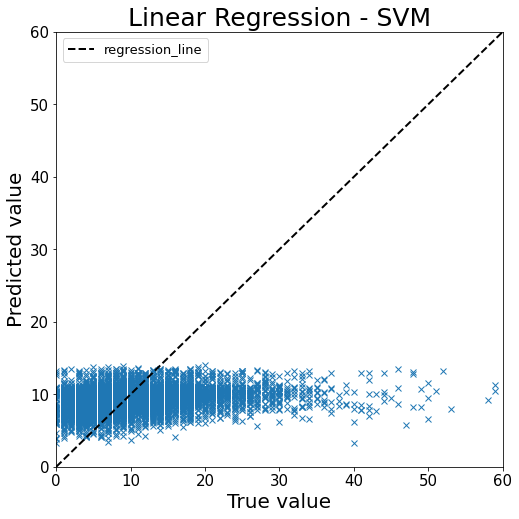

In [23]:
plt.figure(figsize=(8,8))
plt.rc('axes', titlesize=25)   
plt.rc('axes', labelsize=20)  
plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15) 
plt.rc('legend', fontsize=13)

plt.plot(Y_test2, Y_pred, 'x')
plt.plot([0,60],[0,60], 'k--', linewidth=2, label="regression_line")
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Linear Regression - SVM')
plt.legend()

plt.savefig('result/img/reg_svm.png', dpi=300)

##### Y, Predicted Y export (나중에 그래프 그릴 때 사용)

In [24]:
d_trueY = pd.DataFrame({'Y_true':Y_test2}).reset_index(drop=True)
d_predY = pd.DataFrame({'Y_pred':Y_pred})

In [25]:
reg_svm = pd.concat([d_trueY, d_predY], axis = 1).reset_index(drop=True)
reg_svm

,Y_true,Y_pred
0,8,5.191642
1,14,9.652605
2,7,9.431095
3,15,7.229016
4,16,9.424203
...,...,...
6476,11,9.953158
6477,17,7.997489
6478,16,10.100236
6479,15,8.757870


In [26]:
reg_svm.to_csv('C:/workspaces/project/kaggle/result/reg_svm.csv', encoding='utf-8', index=False, line_terminator='\n')